# **Maestría en Inteligencia Artificial Aplicada**

## Curso: **Procesamiento de Lenguaje Natural**

### Tecnológico de Monterrey

### Prof Luis Eduardo Falcón Morales

## Actividad Semana 5

### **Vectores Embebidos de OpenAI**

#### **Nombres y matrículas de los integrantes del equipo:**



*   A00378771 - Hiram Garcia Austria
*   Joaquín Díaz Hernández
* Jesús Antonio López Wayas
* Victor Hugo Vázquez Herrera

In [156]:
# Aquí deberás incluir todas las librerías que requieras durante esta actividad:
import os
import re
import nltk
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from openai import OpenAI
from dotenv import load_dotenv
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

load_dotenv()
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hille\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [126]:
# Incluye las celdas necesarias para tu acceso a la API de OpenAI.
api_key = os.getenv("OPENAI_API_KEY")
open_ai = OpenAI(api_key=api_key)

# **Pregunta - 1:**



Descarga los 3 archivos de Canvas y genera un nuevo DataFrame de Pandas con ellos.

**Llama simplemente "df" a dicho DataFrame.**

Los archivos los encuentras en Canvas: amazon5.txt, imdb5.txt, yelp5.txt.



In [121]:

# ******* Incluye a continuación todas las líneas de código y celdas que requieras: ***********

df_amazon = pd.read_csv('./amazon5.txt', sep='\t', header=None)
df_imdb = pd.read_csv('./imdb5.txt', sep=' {2,}', header=None)
df_yelp = pd.read_csv('./yelp5.txt', sep='\t', header=None)

# Juntando los tres data frames en uno solo
df = pd.concat([df_amazon, df_imdb, df_yelp], ignore_index=True)
df.columns = ['review', 'rating']

# *********** Aquí termina la sección de agregar código *************


C:\Users\hille\AppData\Local\Temp\ipykernel_22632\3986536293.py:4: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df_imdb = pd.read_csv('./imdb5.txt', sep=' {2,}', header=None)


In [125]:
# Verifiquemos la información del DataFrame:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   review  3000 non-null   object
 1   rating  3000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 47.0+ KB


In [127]:
# Y veamos sus primeros registros:

# Para mostrar todo el texto sin cortes
pd.set_option('display.max_colwidth', None)
df.head(25)

,review,rating
0,So there is no way for me to plug it in here in the US unless I go by a converter.,0
1,"Good case, Excellent value.",1
2,Great for the jawbone.,1
3,Tied to charger for conversations lasting more than 45 minutes.MAJOR PROBLEMS!!,0
4,The mic is great.,1
5,I have to jiggle the plug to get it to line up right to get decent volume.,0
6,"If you have several dozen or several hundred contacts, then imagine the fun of sending each of them one by one.",0
7,If you are Razr owner...you must have this!,1
8,"Needless to say, I wasted my money.",0
9,What a waste of money and time!.,0


# **Pregunta - 2:**

Realiza el proceso de limpieza. Aplica el preprocesamiento que consideres adecuado.











In [128]:
# ******* Incluye a continuación todas las líneas de código y celdas que requieras: ***********

# Negaciones en inglés:
negwords = [ 'no', 'nor', 'not', 'ain', 'aren', "aren't", 'don', "don't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'mightn', "mightn't", 'mustn', "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"]

my_stopwords = []

# Excluir palabras negativas de la lista de stopwords
for s_word in stopwords.words('english'):
    if s_word not in negwords:
        my_stopwords.append(s_word)

# Función para tokenizar y limpiar el texto
def tokenizar_y_limpiar(doc):
  # 1. Convierte el texto a minúsculas.
  doc = doc.lower()
  # 2. Conservar solamente los caracteres alfanuméricos, sin espacios, números o signos de puntuación.
  doc = re.sub(r'[^a-z]', ' ', doc)
  # 3. Eliminar mas de un espacio entre palabras y quitar espacios al principio y al final.
  doc = re.sub(r'\s+', ' ', doc).strip()
  # 4. Tokenizar el texto, eliminar las stopwords, y conservar solamente los tokens mayores a 1 carácter.
  tokens = [x for x in doc.split() if x not in my_stopwords and len(x) > 1]
  
  return tokens

# Función para limpiar el texto con stemming y lemmatization
def normalizar_texto(doc):
  ps = PorterStemmer()
  lemmatizer = WordNetLemmatizer()

  # Aplicando el stemming a cada token
  tokens = [ps.stem(x) for x in doc]
  # Lemmatizando cada token
  tokens = [lemmatizer.lemmatize(x) for x in tokens]

  return tokens

Xclean = [tokenizar_y_limpiar(review) for review in df.review]
Xclean = [normalizar_texto(x) for x in Xclean]
Y = df.rating

# *********** Aquí termina la sección de agregar código *************

In [129]:
# Despleguemos los primeros comentarios después de tu proceso de limpieza:

for x in Xclean[0:25]:
  print(x)


['no', 'way', 'plug', 'u', 'unless', 'go', 'convert']
['good', 'case', 'excel', 'valu']
['great', 'jawbon']
['tie', 'charger', 'convers', 'last', 'minut', 'major', 'problem']
['mic', 'great']
['jiggl', 'plug', 'get', 'line', 'right', 'get', 'decent', 'volum']
['sever', 'dozen', 'sever', 'hundr', 'contact', 'imagin', 'fun', 'send', 'one', 'one']
['razr', 'owner', 'must']
['needless', 'say', 'wast', 'money']
['wast', 'money', 'time']
['sound', 'qualiti', 'great']
['impress', 'go', 'origin', 'batteri', 'extend', 'batteri']
['two', 'seper', 'mere', 'ft', 'start', 'notic', 'excess', 'static', 'garbl', 'sound', 'headset']
['good', 'qualiti', 'though']
['design', 'odd', 'ear', 'clip', 'not', 'comfort']
['highli', 'recommend', 'one', 'blue', 'tooth', 'phone']
['advis', 'everyon', 'not', 'fool']
['far', 'good']
['work', 'great']
['click', 'place', 'way', 'make', 'wonder', 'long', 'mechan', 'would', 'last']
['went', 'motorola', 'websit', 'follow', 'direct', 'could', 'not', 'get', 'pair']
['bough

# **Pregunta - 3:**



Realicemos una partición aleatoria con los mismos porcentajes de la práctica pasada para poder comparar dichos resultados con los de
esta actividad, a saber, 70%, 15% y 15%, para entrenamiento, validación y prueba, respectivamente.

In [130]:

# ************* Inicia la sección de agregar código:*****************************

x_train, x_val_and_test, y_train, y_val_and_test = train_test_split(Xclean, Y, train_size=.70, shuffle=True, random_state=1) 
x_val, x_test, y_val, y_test = train_test_split(x_val_and_test, y_val_and_test, test_size=.50, shuffle=True, random_state=17)

# *********** Termina la sección de agregar código *************


# verifiquemos las dimensiones obtenidas:
print('X,y Train:', len(x_train), len(y_train))
print('X,y Val:', len(x_val), len(y_val))
print('X,y Test', len(x_test), len(y_test))

X,y Train: 2100 2100
X,y Val: 450 450
X,y Test 450 450


# **Pregunta - 4:**



Construye tu vocabulario a continuación


In [ ]:
# a.	Usa el conjunto de entrenamiento para generar tu vocabulario
#     con un tamaño que consideres adecuado:


# ******* Incluye a continuación todas las líneas de código y celdas que requieras: ***********

mi_diccionario = Counter()

for comentario in range(len(x_train)):
    mi_diccionario.update(x_train[comentario])

print('Longitud original del vocabulario:', len(mi_diccionario))
# Conservar unicamente las palabras que aparecen más de 1 vez:
mi_diccionario = Counter({token: frecuencia for token, frecuencia in mi_diccionario.items() if frecuencia > 1})

# *********** Aquí termina la sección de agregar código *************

Longitud original del vocabulario: 3166


In [132]:
# b.	Indica el tamaño del vocabulario generado.

print('Longitud del vocabulario generado:', len(mi_diccionario))

# ******* Inicia la sección de agregar código: ***********

print('10 palabras con mayor frecuencia:') 
print(mi_diccionario.most_common(10))

# *********** Aquí termina la sección de agregar código *************

Longitud del vocabulario generado: 1452
10 palabras con mayor frecuencia:
[('not', 218), ('good', 164), ('movi', 140), ('great', 139), ('phone', 134), ('film', 130), ('work', 113), ('time', 102), ('like', 101), ('one', 100)]


c.	¿Por qué debe usarse solamente el conjunto de entrenamiento para generar el vocabulario?


### ++++++++ Inicia la sección de agregar texto: +++++++++++

Usamos el conjunto de entrenamiento para generar nuestro vocabulario por que es el que contiene una mayor cantidad de datos y es el que se usa para entrenar el modelo. No debemos usar los otros conjuntos ya que son los datos con los que validaremos y probaremos la eficacia de nuestro modelo.

Al filtrar el vocabulario, dejando solo las palabras que aparecen al menos 5 veces, evitamos incluir palabras poco relevantes. Esto nos ayuda a enfocarnos en las palabras que realmente aportan valor a nuestro modelo.

### ++++++++ Termina la sección de agregar texto: +++++++++++


In [133]:
# d.	Con el vocabulario generado, filtra los conjuntos de entrenamiento,
#     validación y prueba para que todos los comentarios usen solamente las
#     palabras de este vocabulario.

#     Llamar train_x, val_x y test_x a estos tres conjuntos.


# ******* Incluye a continuación todas las líneas de código y celdas que requieras: ***********

def filtrar_conjunto(conjunto, diccionario):
    resultado = []
    for review in conjunto:
        resultado.append([palabra for palabra in review if palabra in diccionario])
    return resultado

train_x = filtrar_conjunto(x_train, mi_diccionario)
val_x = filtrar_conjunto(x_val, mi_diccionario)
test_x = filtrar_conjunto(x_test, mi_diccionario)


# *********** Aquí termina la sección de agregar código *************


In [134]:
# Vemos el resultado de los primeros comentarios del conjunto de entrenamiento:

for ss in train_x[0:5]:
  print(ss)

['star', 'don', 'fare', 'much', 'better', 'peopl', 'like', 'morgan', 'ed', 'wast']
['tonight', 'filet', 'special', 'suck']
['paid', 'bill', 'not', 'tip', 'felt', 'server', 'terribl', 'job']
['call', 'properli', 'cook', 'steak', 'don', 'understand']
['howev', 'keypad', 'tinni', 'sometim', 'reach', 'wrong', 'button']


# **Pregunta - 5:**


#### **Incluye aquí un resumen de las características y diferencias que tiene al menos los tres modelos de OpenAI indicados: "text-embedding-3-small", "text-embedding-3-large" y "text-embedding-ada-002".**

### ++++++++ Inicia la sección de agregar texto: +++++++++++

**text-embedding-3-small:** Este modelo es una versión más pequeña y rápida, ideal para tareas que requieren menos recursos computacionales. Ofrece un buen balance entre velocidad y precisión, siendo adecuado para aplicaciones en tiempo real o con limitaciones de hardware.

**text-embedding-3-large:** Este modelo es más grande y preciso, diseñado para tareas que requieren una comprensión más profunda del contexto. Es ideal para aplicaciones que necesitan alta precisión en la generación de embeddings, aunque puede ser más lento y requerir más recursos computacionales.

**text-embedding-ada-002:** Este modelo es una versión avanzada que combina la eficiencia de los modelos pequeños con la precisión de los modelos grandes. Es adecuado para una amplia gama de tareas, ofreciendo un buen rendimiento en términos de velocidad y precisión, y es especialmente útil para aplicaciones que requieren embeddings de alta calidad sin comprometer demasiado el tiempo de respuesta.

### Comparativa general

| Modelo                    | Precisión MTEB | Máx. entrada (tokens) | Páginas por dólar |
|---------------------------|----------------|----------------------|-------------------|
| text-embedding-3-small    | 62.3%          | 8192                 | 62,500            |
| text-embedding-3-large    | 64.6%          | 8192                 | 9,615             |
| text-embedding-ada-002    | 61.0%          | 8192                 | 12,500            |

Fuente:  https://platform.openai.com/docs/guides/embeddings#embedding-models

### ++++++++ Termina la sección de agregar texto: +++++++++++


# **Pregunta - 6:**


#### **Diccionario clave-valor de palabras del diccionario y vectores embebidos.**

In [ ]:
vectores_embebidos2 = {}
tokens_utilizados2 = 0

# Generamos los vectores para cada comentario del conjunto de entrenamiento
for comentario in mi_diccionario:
    response = open_ai.embeddings.create(
        input=comentario,
        model="text-embedding-ada-002"
    )
    vectores_embebidos2[comentario] = response.data[0].embedding
    tokens_utilizados2 += response.usage.total_tokens

In [ ]:
# ******* Incluye a continuación todas las líneas de código y celdas que requieras: ***********

print('Número de vectores generados:', len(vectores_embebidos2))
# Verificamos el tamaño de los vectores generados
print('Tamaño de cada vector:', len(next(iter(vectores_embebidos2.values()))))
# Verificamos el primer vector generado
print('Primer vector generado:', vectores_embebidos2.get("star"))

# Guardamos los embeddings en un archivo JSON
with open('embeddings.json', 'w') as f:
    json.dump(vectores_embebidos2, f)

# *********** Aquí termina la sección de agregar código *************

Número de vectores generados: 1452
Tamaño de cada vector: 1536
Primer vector generado: [0.011688734404742718, -0.009672462940216064, -0.013972901739180088, -0.01744145341217518, -0.020402410998940468, 0.0075292931869626045, -0.008276582695543766, -0.005245125386863947, -0.0012839629780501127, -0.017681149765849113, 0.018329739570617676, 0.01944362372159958, -0.0035954490303993225, -0.0010284041054546833, -0.005093552637845278, 0.009707712568342686, 0.03076576255261898, -0.00852332916110754, 0.011434937827289104, -0.02687421813607216, -0.019189827144145966, 0.02371586300432682, -0.0016822824254631996, 0.012520622462034225, 0.006454183254390955, 0.0011015469208359718, 0.014142099767923355, -0.01848483830690384, 0.010356303304433823, 0.0073389457538723946, 0.006665680557489395, -0.027367711067199707, -0.0012769130989909172, -0.025379639118909836, -0.02154449373483658, -0.00990510918200016, -0.014395895414054394, -0.01840023882687092, 0.004191165324300528, 0.0034509259276092052, 0.02604233

# **Pregunta - 7:**



Generamos los vectores embebidos a partir de los conjuntos de entrenamiento, validación y prueba.

Los llamaremos trainEmb, valEmb y testEmb, respectivamente.

In [ ]:


# ******* Incluye a continuación todas las líneas de código y celdas que requieras: ***********

# Crear vector embebido por comentario, promediando los vectores de cada una de sus palabras
def generar_vectores_embebidos(comentarios, diccionario):
    vectores_embebidos = []
    for comentario in comentarios:
        vector_review = [0] * len(next(iter(diccionario.values())))
        for palabra in comentario:
            if palabra in diccionario:
                vector_review = [sum(x) for x in zip(vector_review, diccionario[palabra])]
        # Promediar el vector
        if len(comentario) > 0:
            vector_review = [x / len(comentario) for x in vector_review]
        vectores_embebidos.append(vector_review)
    return pd.DataFrame(np.array(vectores_embebidos))

trainEmb = generar_vectores_embebidos(train_x, vectores_embebidos2)
valEmb = generar_vectores_embebidos(val_x, vectores_embebidos2)
testEmb = generar_vectores_embebidos(test_x, vectores_embebidos2)

# *********** Aquí termina la sección de agregar código *************

In [146]:
# Veamos las dimensiones de cada conjunto embebido:

print("Train-Emb:", trainEmb.shape)
print("Val-Emb:", valEmb.shape)
print("Test-Emb:", testEmb.shape)

Train-Emb: (2100, 1536)
Val-Emb: (450, 1536)
Test-Emb: (450, 1536)


# **Pregunta - 8:**



Utiliza los modelos de regresión logística y bosque aleatorio (random forest) y encuentra sus desempeños.

Compara los resultados con los de la semana anterior.

In [150]:
# REGRESIÓN LOGÍSTICA:

# ******* Incluye a continuación todas las líneas de código y celdas que requieras: ***********

modelo_logistico = LogisticRegression(max_iter=1000)
modelo_logistico.fit(trainEmb, y_train)

# Predicciones en el conjunto de validación
predicciones_logistico = modelo_logistico.predict(valEmb)

# Cálculo de la exactitud y reporte
exactitud_logistico = accuracy_score(y_val, predicciones_logistico)
reporte_logistico = classification_report(y_val, predicciones_logistico)

print("Regresión Logística:")
print("Exactitud:", exactitud_logistico)
print("Reporte de clasificación:\n", reporte_logistico)

# *********** Aquí termina la sección de agregar código *************


Regresión Logística:
Exactitud: 0.8266666666666667
Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.80      0.85      0.83       216
           1       0.85      0.80      0.83       234

    accuracy                           0.83       450
   macro avg       0.83      0.83      0.83       450
weighted avg       0.83      0.83      0.83       450



### Comparación con los resultados de la actividad anterior
La semana pasada, el modelo de regresión logística tenía una exactitud de 0.75 y un reporte de clasificación similar.

Esta semana, con el uso de embeddings, la exactitud ha mejorado a 0.82, lo que indica un mejor rendimiento del modelo.

Podemos observar que la precisión y el recall para las clases positivas han mejorado, lo que sugiere que el modelo es más efectivo en la identificación de reseñas positivas.

También podemos notar que el modelos no esta sobre entrenado, ya que la exactitud en el conjunto de validación es similar a la del conjunto de entrenamiento.

In [152]:
# BOSQUE ALEATORIO (Random Forest):

# ******* Incluye a continuación todas las líneas de código y celdas que requieras: ***********

modelo_bosque_aleatorio = RandomForestClassifier(n_estimators=100, random_state=42)
modelo_bosque_aleatorio.fit(trainEmb, y_train)

# Predicciones en el conjunto de validación
predicciones_bosque_aleatorio = modelo_bosque_aleatorio.predict(valEmb)

# Cálculo de la exactitud y reporte
exactitud_bosque_aleatorio = accuracy_score(y_val, predicciones_bosque_aleatorio)
reporte_bosque_aleatorio = classification_report(y_val, predicciones_bosque_aleatorio)

print("Bosque Aleatorio:")
print("Exactitud:", exactitud_bosque_aleatorio)
print("Reporte de clasificación:\n", reporte_bosque_aleatorio)


# *********** Aquí termina la sección de agregar código *************

Bosque Aleatorio:
Exactitud: 0.7955555555555556
Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.76      0.85      0.80       216
           1       0.84      0.75      0.79       234

    accuracy                           0.80       450
   macro avg       0.80      0.80      0.80       450
weighted avg       0.80      0.80      0.80       450



### Comparación con los resultados de la actividad anterior
La semana pasada, el modelo de bosque aleatorio tenía una exactitud de 0.85.

Esta semana, con el uso de embeddings, la exactitud ha bajado a 0.80, lo que indica un rendimiento ligeramente inferior al de la semana pasada.

Podemos confirmar que el modelo no está sobre entrenado, ya que la exactitud en el conjunto de validación es similar a la del conjunto de entrenamiento.

# **Pregunta - 9:**



Reporte del mejor modelo con el conjunto de Prueba (Test).


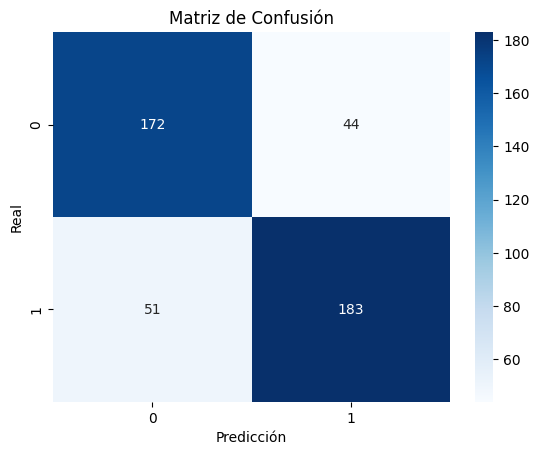

Resultados del mejor modelo (Regresión Logística):
              precision    recall  f1-score   support

           0       0.77      0.80      0.78       216
           1       0.81      0.78      0.79       234

    accuracy                           0.79       450
   macro avg       0.79      0.79      0.79       450
weighted avg       0.79      0.79      0.79       450



In [157]:
import seaborn as sns

# ******* Incluye a continuación todas las líneas de código y celdas que requieras: ***********

# Usando la regresión logística
mejor_modelo = modelo_logistico
predicciones_test = mejor_modelo.predict(testEmb)
matriz_confusion = confusion_matrix(y_test, predicciones_test)

sns.heatmap(matriz_confusion, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión')
plt.show()

print("Resultados del mejor modelo (Regresión Logística):")
print(classification_report(y_test, predicciones_test))

# *********** Aquí termina la sección de agregar código *************

# **Pregunta - 10:**

In [166]:
# Incluye todas las líneas de código y celdas que consideres adecuadas para este ejercicio.

vectores_embebidos2 = []
tokens_utilizados2 = 0

for comentario in df.review:
    response = open_ai.embeddings.create(
        input=comentario,
        model="text-embedding-ada-002"
    )
    vectores_embebidos2.append(response.data[0].embedding)
    tokens_utilizados2 += response.usage.total_tokens


In [170]:
# Partición en Train-Val-Test del 70%, 15% y 15%, respectivamente.
x_train2, x_val_and_test2, y_train2, y_val_and_test2 = train_test_split(vectores_embebidos2, Y, train_size=.70, shuffle=True, random_state=1) 
x_val2, x_test2, y_val2, y_test2 = train_test_split(x_val_and_test2, y_val_and_test2, test_size=.50, shuffle=True, random_state=17)

# Verificamos las dimensiones obtenidas:
print('X,y Train:', len(x_train2), len(y_train2))
print('X,y Val:', len(x_val2), len(y_val2))
print('X,y Test', len(x_test2), len(y_test2))

X,y Train: 2100 2100
X,y Val: 450 450
X,y Test 450 450


In [171]:
# Regresión Logística
modelo_logistico2 = LogisticRegression(max_iter=1000)
modelo_logistico2.fit(x_train2, y_train2)

# Predicciones en el conjunto de validación
predicciones_logistico2 = modelo_logistico2.predict(x_val2)

# Cálculo de la exactitud y reporte
exactitud_logistico2 = accuracy_score(y_val2, predicciones_logistico2)
reporte_logistico2 = classification_report(y_val2, predicciones_logistico2)

print("Regresión Logística (con embeddings):")
print("Exactitud:", exactitud_logistico2)
print("Reporte de clasificación:\n", reporte_logistico2)

Regresión Logística (con embeddings):
Exactitud: 0.9844444444444445
Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.98      0.99      0.98       216
           1       0.99      0.98      0.99       234

    accuracy                           0.98       450
   macro avg       0.98      0.98      0.98       450
weighted avg       0.98      0.98      0.98       450



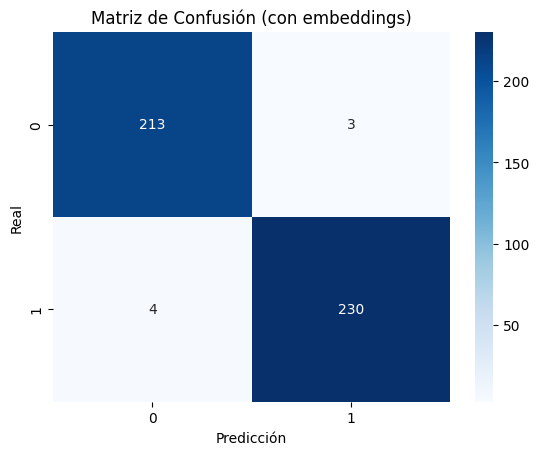

In [ ]:
matriz_confusion2 = confusion_matrix(y_test2, modelo_logistico2.predict(x_test2))
sns.heatmap(matriz_confusion2, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión (con embeddings)')
plt.show()


In [172]:
# Bosque Aleatorio
modelo_bosque_aleatorio2 = RandomForestClassifier(n_estimators=100, random_state=42)
modelo_bosque_aleatorio2.fit(x_train2, y_train2)

# Predicciones en el conjunto de validación
predicciones_bosque_aleatorio2 = modelo_bosque_aleatorio2.predict(x_val2)

# Cálculo de la exactitud y reporte
exactitud_bosque_aleatorio2 = accuracy_score(y_val2, predicciones_bosque_aleatorio2)
reporte_bosque_aleatorio2 = classification_report(y_val2, predicciones_bosque_aleatorio2)

print("Bosque Aleatorio (con embeddings):")
print("Exactitud:", exactitud_bosque_aleatorio2)
print("Reporte de clasificación:\n", reporte_bosque_aleatorio2)

Bosque Aleatorio (con embeddings):
Exactitud: 0.98
Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.97      0.99      0.98       216
           1       0.99      0.97      0.98       234

    accuracy                           0.98       450
   macro avg       0.98      0.98      0.98       450
weighted avg       0.98      0.98      0.98       450



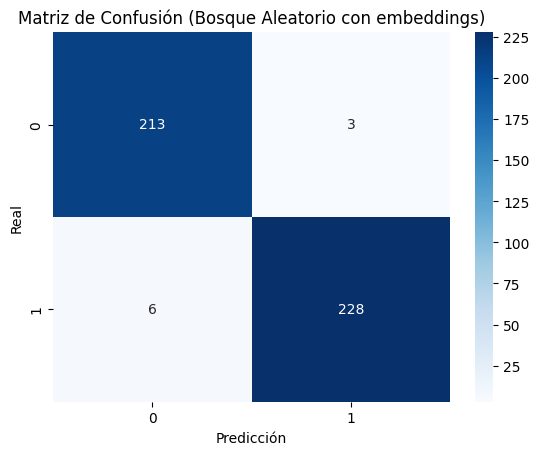

In [175]:
matriz_confusion3 = confusion_matrix(y_test2, modelo_bosque_aleatorio2.predict(x_test2))
sns.heatmap(matriz_confusion3, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión (Bosque Aleatorio con embeddings)')
plt.show()

# **Pregunta - 11:**

Incluye tus comentarios finales de la actividad.

### ++++++++ Inicia la sección de agregar texto: +++++++++++

1. El modelo de Regresión Logística con embeddings logró una exactitud de 0.9844 en el conjunto de validación.

2. El modelo de Bosque Aleatorio con embeddings logró una exactitud de 0.98 en el conjunto de validación.

3. Ambos modelos mostraron un buen desempeño, pero la Regresión Logística tuvo una ligera ventaja en términos de exactitud.

4. La matriz de confusión indica que ambos modelos son capaces de clasificar correctamente la mayoría de los comentarios, aunque hay algunas confusiones entre las clases. Pero ambas son substancialmente mejores que las de los modelos anteriores.

5. Dado que hemos utilizado un modelo pre-entrenado de OpenAI, es menos probable que estemos sobre entrenando el modelo, ya que los embeddings ya han sido entrenados en un gran corpus de texto y capturan relaciones semánticas más generales.

### ++++++++ Termina la sección de agregar texto: +++++++++++

# **Fin de la Actividad de Vectores Embebidos - OpenAI**